## Dicoding: Proyek Akhir_Klasifikasi Gambar - Belajar Machine Learning untuk Pemula

---


- ### Name: Ridwan Halim
- ### url Dicoding: [dicoding.com/users/ridwaanhall](https://www.dicoding.com/users/ridwaanhall/academies)
- ### url google colab: [click here](https://colab.research.google.com/drive/1Otttp1LZtUw-fR_BaAeA2Dj7ayNYJI2Z?usp=sharing!)

- ### github repo: [click here](https://github.com/ridwaanhall/Dicoding_Proyek-Akhir_Klasifikasi-Gambar_Belajar-Machine-Learning-untuk-Pemula)


---


># Make sure you're using runtime T4 GPU.




## installation

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a380c683fcbf16ff5140515c833ba8e6277e58f6deaea235779681181888be07
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Import Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
import zipfile
import os
import wget
import glob
import time
import requests
from PIL import Image
from io import BytesIO

## Classes

### Dataset Processor

In [4]:
class DatasetProcessor:
    def __init__(self, url, dataset_zip, dataset_dir):
        self.url = url
        self.dataset_zip = dataset_zip
        self.dataset_dir = dataset_dir

    def download_and_extract(self):
        wget.download(self.url, self.dataset_zip)
        with zipfile.ZipFile(self.dataset_zip, 'r') as zip_ref:
            zip_ref.extractall(self.dataset_dir)
        print("Dataset downloaded and extracted successfully.")

    def prepare_data_generators(self):
        base_dir = os.path.join(self.dataset_dir, 'rockpaperscissors', 'rps-cv-images')

        if not os.path.exists(base_dir):
            raise Exception(f"Base directory {base_dir} does not exist.")

        categories = ['rock', 'paper', 'scissors']
        for category in categories:
            if len(glob.glob(f"{base_dir}/{category}/*")) == 0:
                raise Exception(f"No images found in category {category}.")

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.4  # 40% for validation
        )
        self.train_generator = train_datagen.flow_from_directory(
            base_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='categorical',
            subset='training'  # Set as training data
        )
        self.validation_generator = train_datagen.flow_from_directory(
            base_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='categorical',
            subset='validation'  # Set as validation data
        )
        print("Data generators prepared successfully.")
        return self.train_generator, self.validation_generator

### Model Builder

#### make sure you already change runtime (Hardware accelerator) to T4 GPU
- go to Runtime in top of colab -> change runtime type -> Hardware accelerator -> T4 GPU

In [5]:
class ModelBuilder:
    def __init__(self):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

    def compile_model(self):
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy']
        )
        print("Model compiled successfully.")

    def train_model(self, train_generator, validation_generator):
        start_time = time.time()
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // 32,
            epochs=75,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // 32,
            verbose=2
        )
        end_time = time.time()
        total_time = end_time - start_time
        avg_time_per_epoch = total_time / 75

        print(f"Total training time   : {total_time:.3f} seconds ({total_time / 60:.3f} minutes)")
        print(f"Average time per epoch: {avg_time_per_epoch:.3f} seconds/epoch")
        print("Model trained successfully.")

    def evaluate_model(self):
        acc = self.history.history['accuracy'][-1]
        val_acc = self.history.history['val_accuracy'][-1]
        print(f"Training accuracy     : {acc:.5f}")
        print(f"Validation accuracy   : {val_acc:.5f}")
        assert val_acc >= 0.85, "Validation accuracy is below 85%"
        print("Model evaluation completed successfully.")

    def plot_training_history(self):
        # accuracy values
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # loss values
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
        print("Training history plotted successfully.")

### Image Predictor

In [6]:
class ImagePredictor:
    def __init__(self, model, class_labels):
        self.model = model
        self.class_labels = class_labels

    def predict_image(self):
        uploaded = files.upload()
        for fn in uploaded.keys():
            path = fn
            img = image.load_img(path, target_size=(150, 150))
            img_tensor = image.img_to_array(img)
            img_tensor = np.expand_dims(img_tensor, axis=0)
            img_tensor /= 255.
            prediction = self.model.predict(img_tensor)
            predicted_class = np.argmax(prediction, axis=1)
            predicted_label = self.class_labels[predicted_class[0]]

            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Predicted: {predicted_label}")
            plt.show()

            print(f"The uploaded image is a {predicted_label}")

## Process Dataset

40% (train: 1314, val: 874)

In [7]:
dataset_processor = DatasetProcessor(
    url='https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip',
    dataset_zip='rockpaperscissors.zip',
    dataset_dir='rockpaperscissors'
)
dataset_processor.download_and_extract()
train_generator, validation_generator = dataset_processor.prepare_data_generators()

Dataset downloaded and extracted successfully.
Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
Data generators prepared successfully.


## Model Contoller

### Build and Compile Model

In [8]:
model_builder = ModelBuilder()
model_builder.compile_model()

Model compiled successfully.


### Train Model

In [9]:
model_builder.train_model(train_generator, validation_generator)

Epoch 1/75
41/41 - 28s - loss: 1.0843 - accuracy: 0.3775 - val_loss: 1.0274 - val_accuracy: 0.4433 - 28s/epoch - 685ms/step
Epoch 2/75
41/41 - 19s - loss: 0.9809 - accuracy: 0.5101 - val_loss: 0.8472 - val_accuracy: 0.6470 - 19s/epoch - 462ms/step
Epoch 3/75
41/41 - 20s - loss: 0.9238 - accuracy: 0.6006 - val_loss: 0.9761 - val_accuracy: 0.4942 - 20s/epoch - 497ms/step
Epoch 4/75
41/41 - 16s - loss: 0.7018 - accuracy: 0.6911 - val_loss: 0.3968 - val_accuracy: 0.8704 - 16s/epoch - 389ms/step
Epoch 5/75
41/41 - 20s - loss: 0.3830 - accuracy: 0.8690 - val_loss: 0.2503 - val_accuracy: 0.9178 - 20s/epoch - 488ms/step
Epoch 6/75
41/41 - 20s - loss: 0.3174 - accuracy: 0.8963 - val_loss: 0.2348 - val_accuracy: 0.9294 - 20s/epoch - 479ms/step
Epoch 7/75
41/41 - 17s - loss: 0.2638 - accuracy: 0.9126 - val_loss: 0.2366 - val_accuracy: 0.9109 - 17s/epoch - 405ms/step
Epoch 8/75
41/41 - 20s - loss: 0.2143 - accuracy: 0.9284 - val_loss: 0.2381 - val_accuracy: 0.9155 - 20s/epoch - 490ms/step
Epoch 9/

### Evaluate Model

In [10]:
model_builder.evaluate_model()

Training accuracy     : 0.98128
Validation accuracy   : 0.98611
Model evaluation completed successfully.


## Plot Training History

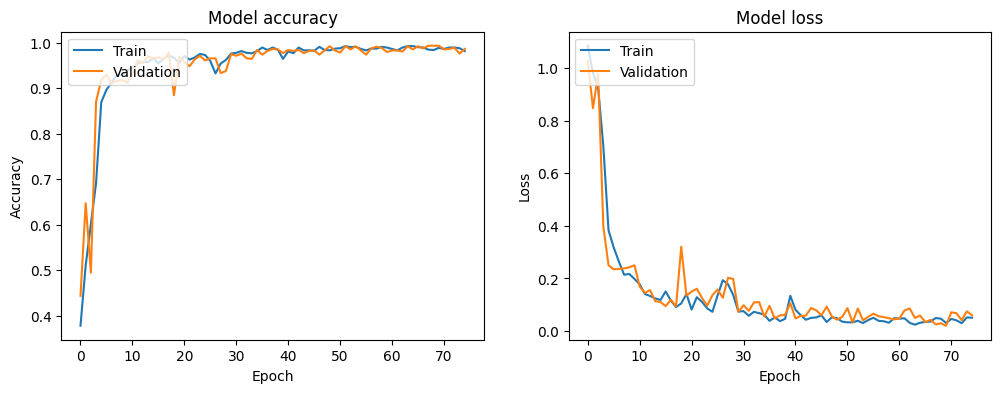

Training history plotted successfully.


In [11]:
model_builder.plot_training_history()

## Predict Image

In [12]:
# Image Predictor
image_predictor = ImagePredictor(model=model_builder.model, class_labels=list(train_generator.class_indices.keys()))

Saving scissors.png to scissors.png
1/1 [==============================] - 0s 395ms/step


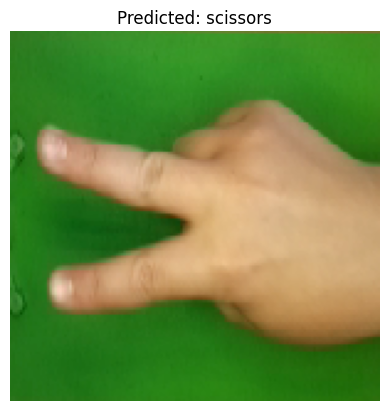

The uploaded image is a scissors


In [13]:
# test scissors
image_predictor.predict_image()

Saving rock.png to rock.png
1/1 [==============================] - 0s 18ms/step


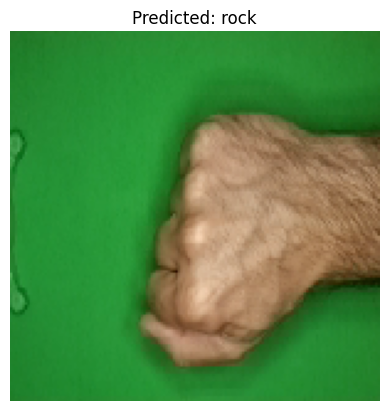

The uploaded image is a rock


In [14]:
# test rock
image_predictor.predict_image()

Saving paper.png to paper.png
1/1 [==============================] - 0s 17ms/step


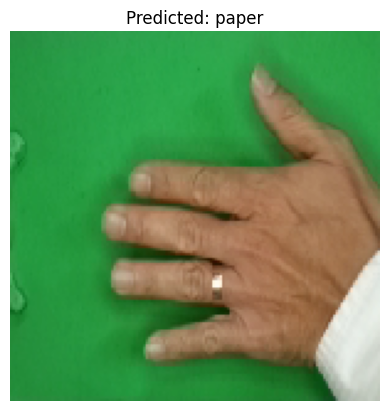

The uploaded image is a paper


In [15]:
# test paper
image_predictor.predict_image()